In [2]:
import numpy as np
from qiskit import BasicAer
#from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit import IBMQ
import pickle
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data



from datetime import datetime

seed = 12348


# Loading your IBM Quantum account(s)


In [3]:
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

import pandas as pd


In [4]:
#set backend
IBMQ.save_account('ab57ee0cefb0e9dad544e4654f04acd4b277a9234129269b97ebebf6cd82e1b7a3d64e1f44006b01a1c3bb136589819486e6f408210e56bbbdd5cf795d056344',overwrite=True)
provider = IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider('ibm-q','open','main')
#provider = IBMQ.get_provider('partner-cnr','iit','qml-for-genomics')

num_qubits = 2

from qiskit.providers.ibmq import least_busy
possible_devices = provider.backend(filters=lambda x: 
        x.configuration().n_qubits >= num_qubits
                                       and 
        x.configuration().simulator == True)
#backend = least_busy(possible_devices)
print(possible_devices)




TypeError: 'IBMQBackendService' object is not callable

In [5]:
backend=provider.get_backend('ibmq_qasm_simulator')

In [19]:
print(backend)

ibmq_qasm_simulator


In [6]:
#Load training data

xlr = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_xlr.txt", sep = "\t")
nsd = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_nsd.txt", sep = "\t")
sd = pd.read_csv("/CTGlab/home/elia/qiskit test/dataset/test_sd.txt", sep = "\t")

In [7]:
all_columns = ['MeanCvg', 'NRC_poolNorm', 'Class']
features = all_columns[:-1]
labels = all_columns[-1]

X_train, X_test, y_train, y_test = train_test_split(xlr[features], xlr[labels], train_size=500, random_state=42,stratify=xlr[labels])

# %%
scaler = MinMaxScaler(feature_range = (0, 2*np.pi))
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

nsd_scaled = scaler.transform(nsd[features])
sd_scaled = scaler.transform(sd[features])

y_nsd = nsd[labels]
y_sd = sd[labels]

## Quantum kernel with sklearn.SVC

In [17]:
#define kernel and quantumInstance
num_qubits = 2
shots= 1024
feature_map = ZZFeatureMap(feature_dimension=num_qubits,entanglement='linear')

quantum_instance = QuantumInstance(backend,shots=shots,skip_qobj_validation=False)

adhoc_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)#Creation of k



In [18]:
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

In [19]:
time_quntum=datetime.now()
adhoc_svc.fit(X_train_scaled, y_train)
print('tempo esecuzione fit quantum:', datetime.now()-time_quntum)


tempo esecuzione fit quantum: 1:34:08.410597


# SVC Optimization

SVC optimization with Halving algorithm

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

range(0, 2)

In [ ]:
param_grid = {"C":[x for x in range(1,100)]/100,
              "tol":[1e-2] }
search = HalvingGridSearchCV(adhoc_svc, param_grid, resource='n_samples' ,max_resources='auto',random_state=0,refit=True).fit(X_train_scaled, y_train)

In [ ]:
svc_opt=search.best_estimator_
print(svc_opt)
print(search.best_params_)

In [22]:


def is_picklable(obj):
    try:
        pickle.dumps(obj)
    except Exception:
        return False
    return True


bk = {}
for k in dir():
    obj = globals()[k]
    if is_picklable(obj):
        try:
            bk.update({k: obj})
        except TypeError:
            pass

# to save session
with open('./After_fit_5000pt_sim_bk.pkl', 'wb') as f2:
    pickle.dump(bk, f2)


/tmp/ipykernel_1933515/2952383858.py:5: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dumps(obj)


In [24]:

# save the model to disk
filename = 'qsvc_sim_5000pt.pkl'
pickle.dump(adhoc_svc, open(filename, 'wb'))
 

In [8]:
xlr_eval, _, y_xlr_eval, _ = train_test_split(X_test_scaled, y_test, train_size= 5000, random_state=42,stratify=y_test)
nsd_eval, _, y_nsd_eval, _ = train_test_split(nsd_scaled, y_nsd, train_size= 5000, random_state=42,stratify=y_nsd)
sd_eval, _, y_sd_eval, _ = train_test_split(sd_scaled, y_sd, train_size= 5000, random_state=42,stratify=y_sd)

# %%

In [ ]:
time_xlr=datetime.now()
y_pred = svc_opt.predict(xlr_eval)

qsvc_score_xlr=accuracy_score(y_xlr_eval,y_pred) 
print(f"Callable kernel classification test score XLR: {qsvc_score_xlr}")
print('tempo di esecuzione valutazione xlr:',datetime.now()-time_xlr)


In [ ]:
conf_matrix=confusion_matrix(y_xlr_eval,y_pred)

In [ ]:
bk = {}
for k in dir():
    obj = globals()[k]
    if is_picklable(obj):
        try:
            bk.update({k: obj})
        except TypeError:
            pass

# to save session
with open('./After_classification_xlr_500pt__opt_bk.pkl', 'wb') as f2:
    pickle.dump(bk, f2)


### Figures

In [9]:
import matplotlib.pyplot as plt
def make_meshgrid(x, y, h=0.3):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out, Z



In [ ]:

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface Quantum SVC ZZ feature map')
# Set-up grid for plotting.
X0, X1 = xlr_eval[:, 0], xlr_eval[:, 1]
xx, yy = make_meshgrid(X0, X1)

#plot_contours(ax,adhoc_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z = adhoc_svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
out = ax.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar(out)
ax.scatter(X0, X1, c=y_xlr_eval, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
plt.savefig('./decision_surface_ZZ_ftmap_5000pt_sim.png')

In [28]:
bk = {}
for k in dir():
    obj = globals()[k]
    if is_picklable(obj):
        try:
            bk.update({k: obj})
        except TypeError:
            pass

# to save session
with open('./After_fig_5000pt_sim_bk.pkl', 'wb') as f2:
    pickle.dump(bk, f2)


# Reload session

In [14]:
import pickle
import sys
sys.setrecursionlimit(7000)
with open('qsvc_sim_5000pt.pkl', 'rb') as f:
    qsvc_sim_500 = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


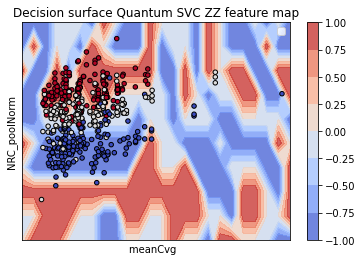

<Figure size 432x288 with 0 Axes>

In [23]:

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface Quantum SVC ZZ feature map')
# Set-up grid for plotting.
X0, X1 = xlr_eval[:, 0], xlr_eval[:, 1]
xx, yy = make_meshgrid(X0, X1,h=0.3)

#plot_contours(ax,adhoc_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z = qsvc_sim_500.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
out = ax.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar(out)
ax.scatter(X0, X1, c=y_xlr_eval, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
plt.savefig('./decision_surface_ZZ_ftmap_5000pt_sim.png')

In [11]:
# save the grid to disk
filename = 'grid_sim_500pt.pkl'
pickle.dump(Z, open(filename, 'wb'))
 

NameError: name 'Z' is not defined

In [25]:
xlr_df=pd.DataFrame(xlr_eval,columns=['NRC_poolNorm','meanCvg'])
xlr_df['label']=y_xlr_eval.to_list()
xlr_df.head()

,NRC_poolNorm,meanCvg,label
0,1.154370,4.997490,-1
1,1.802134,5.303016,-1
2,0.805840,5.872075,1
3,2.827170,5.956272,1
4,0.548080,5.682222,1


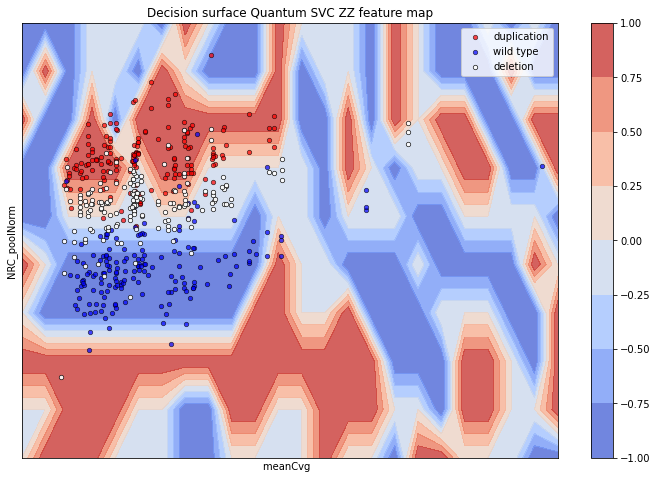

<Figure size 432x288 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
# title for the plots
title = ('Decision surface Quantum SVC ZZ feature map')
out = ax.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar(out)
ax.scatter(xlr_df[xlr_df['label']==1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==1]['meanCvg'], c='r', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='duplication')
ax.scatter(xlr_df[xlr_df['label']==-1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==-1]['meanCvg'], c='b', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='deletion')
ax.scatter(xlr_df[xlr_df['label']==0.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==0]['meanCvg'], c='w', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.9,label='wilde type')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
plt.savefig('./decision_surface_ZZ_ftmap_5000pt_sim.png')

### Figure with smaller grid step and sd

In [12]:


#plot_contours(ax,adhoc_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z_fine = qsvc_sim_500.predict(np.c_[xx.ravel(), yy.ravel()])
Z_fine = Z.reshape(xx.shape)
out = ax.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar(out)
ax.scatter(xlr_df[xlr_df['label']==1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==1]['meanCvg'], c='r', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='duplication')
ax.scatter(xlr_df[xlr_df['label']==-1.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==-1]['meanCvg'], c='b', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.7,label='deletion')
ax.scatter(xlr_df[xlr_df['label']==0.0]['NRC_poolNorm'],xlr_df[xlr_df['label']==0]['meanCvg'], c='w', cmap=plt.cm.coolwarm, s=20,linewidths=.7,edgecolors='k',alpha=0.9,label='wilde type')
ax.set_ylabel('NRC_poolNorm ')
ax.set_xlabel('meanCvg  ')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
plt.savefig('./decision_surface_ZZ_ftmap_sim_sd_fine.png')

IBMQJobFailureError: 'Unable to retrieve result for job 628a4750df04f873ae3db20c. Job has failed. Use the error_message() method to get more details'

In [17]:
X0, X1 = sd_eval[:, 0], sd_eval[:, 1]
xx, yy = make_meshgrid(X0, X1,h=0.1)

In [18]:
#plot_contours(ax,adhoc_svc , xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
Z_fine = qsvc_sim_500.predict(np.c_[xx.ravel(), yy.ravel()])
Z_fine = Z.reshape(xx.shape)

In [ ]:
# save the grid to disk
filename = 'grid_fine_sim_500pt.pkl'
pickle.dump(Z_fine, open(filename, 'wb'))
 

NameError: name 'pickle' is not defined